In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from pathlib import Path
import cv2
from torch.autograd import Variable

In [3]:
# NCNet IVD pretrained (from the oroginal repo)
!gdown 10GZ0x3CmObKzbAg1GKQhrkPeSLRpD4Rp -O /kaggle/working/ncn_ivd_5ep.pth

Downloading...
From: https://drive.google.com/uc?id=10GZ0x3CmObKzbAg1GKQhrkPeSLRpD4Rp
To: /kaggle/working/ncn_ivd_5ep.pth
100%|██████████████████████████████████████| 6.00k/6.00k [00:00<00:00, 17.5MB/s]


In [4]:
# -------------------------------------------------------------
# Device & Transform
# -------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = T.Compose([T.Resize((240, 320)), T.ToTensor(),])

Using device: cuda


In [5]:
#network/ncn/conv4d.py

from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _quadruple

def conv4d(data, filters, bias=None, permute_filters=True, use_half=False):
    b, c, h, w, d, t = data.size()

    data = data.permute(
        2, 0, 1, 3, 4, 5
    ).contiguous()  # permute to avoid making contiguous inside loop

    # Same permutation is done with filters, unless already provided with permutation
    if permute_filters:
        filters = filters.permute(
            2, 0, 1, 3, 4, 5
        ).contiguous()  # permute to avoid making contiguous inside loop

    c_out = filters.size(1)
    if use_half:
        output = Variable(
            torch.HalfTensor(h, b, c_out, w, d, t), requires_grad=data.requires_grad
        )
    else:
        output = Variable(
            torch.zeros(h, b, c_out, w, d, t), requires_grad=data.requires_grad
        )

    padding = filters.size(0) // 2
    if use_half:
        Z = Variable(torch.zeros(padding, b, c, w, d, t).half())
    else:
        Z = Variable(torch.zeros(padding, b, c, w, d, t))

    if data.is_cuda:
        Z = Z.cuda(data.get_device())
        output = output.cuda(data.get_device())

    data_padded = torch.cat((Z, data, Z), 0)

    for i in range(output.size(0)):  # loop on first feature dimension
        # convolve with center channel of filter (at position=padding)
        output[i, :, :, :, :, :] = F.conv3d(
            data_padded[i + padding, :, :, :, :, :],
            filters[padding, :, :, :, :, :],
            bias=bias,
            stride=1,
            padding=padding,
        )
        # convolve with upper/lower channels of filter (at postions [:padding] [padding+1:])
        for p in range(1, padding + 1):
            output[i, :, :, :, :, :] = output[i, :, :, :, :, :] + F.conv3d(
                data_padded[i + padding - p, :, :, :, :, :],
                filters[padding - p, :, :, :, :, :],
                bias=None,
                stride=1,
                padding=padding,
            )
            output[i, :, :, :, :, :] = output[i, :, :, :, :, :] + F.conv3d(
                data_padded[i + padding + p, :, :, :, :, :],
                filters[padding + p, :, :, :, :, :],
                bias=None,
                stride=1,
                padding=padding,
            )

    output = output.permute(1, 2, 0, 3, 4, 5).contiguous()
    return output


class Conv4d(_ConvNd):
    """Applies a 4D convolution over an input signal composed of several input
    planes.
    """

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        bias=True,
        pre_permuted_filters=True,
    ):
        # stride, dilation and groups !=1 functionality not tested
        stride = 1
        dilation = 1
        groups = 1
        # zero padding is added automatically in conv4d function to preserve tensor size
        padding = 0
        kernel_size = _quadruple(kernel_size)
        stride = _quadruple(stride)
        padding = _quadruple(padding)
        dilation = _quadruple(dilation)

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            False,
            _quadruple(0),
            groups,
            bias,
            padding_mode="zeros",
        )

        # weights will be sliced along one dimension during convolution loop
        # make the looping dimension to be the first one in the tensor,
        # so that we don't need to call contiguous() inside the loop
        self.pre_permuted_filters = pre_permuted_filters
        if self.pre_permuted_filters:
            self.weight.data = self.weight.data.permute(2, 0, 1, 3, 4, 5).contiguous()
        self.use_half = False

    def forward(self, input):
        return conv4d(
            input,
            self.weight,
            bias=self.bias,
            permute_filters=not self.pre_permuted_filters,
            use_half=self.use_half,
        )  # filters pre-permuted in constructor

In [6]:
class NeighConsensus(torch.nn.Module):
    def __init__(self, use_cuda=True, kernel_sizes=[3,3,3], channels=[10,10,1], symmetric_mode=True):
        super(NeighConsensus, self).__init__()
        self.symmetric_mode = symmetric_mode
        self.kernel_sizes = kernel_sizes
        self.channels = channels
        num_layers = len(kernel_sizes)
        nn_modules = list()
        for i in range(num_layers):
            if i==0:
                ch_in = 1
            else:
                ch_in = channels[i-1]
            ch_out = channels[i]
            k_size = kernel_sizes[i]
            nn_modules.append(Conv4d(in_channels=ch_in,out_channels=ch_out,kernel_size=k_size,bias=True))
            nn_modules.append(nn.ReLU(inplace=True))
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv = nn.Sequential(*nn_modules).to(device)


    def forward(self, x):
        if self.symmetric_mode:
            # apply network on the input and its "transpose" (swapping A-B to B-A ordering of the correlation tensor),
            # this second result is "transposed back" to the A-B ordering to match the first result and be able to add together
            x = self.conv(x)+self.conv(x.permute(0,1,4,5,2,3)).permute(0,1,4,5,2,3)
            # because of the ReLU layers in between linear layers, 
            # this operation is different than convolving a single time with the filters+filters^T
            # and therefore it makes sense to do this.
        else:
            x = self.conv(x)
        return x

In [7]:
#from network/ncn/model.py

def featureL2Norm(feature):
    epsilon = 1e-6
    norm = torch.pow(torch.sum(torch.pow(feature,2),1)+epsilon,0.5).unsqueeze(1).expand_as(feature)
    feat_norm = torch.div(feature,norm)
    return feat_norm

class FeatureExtraction(torch.nn.Module): #Changed name to match my flow
    def __init__(self, train_fe=False, feature_extraction_cnn='resnet101', feature_extraction_model_file='', normalization=True, last_layer='', use_cuda=True):
        super(FeatureExtraction, self).__init__()
        self.normalization = normalization
        self.feature_extraction_cnn=feature_extraction_cnn
        if feature_extraction_cnn == 'vgg':
            self.model = models.vgg16(pretrained=True)
            # keep feature extraction network up to indicated layer
            vgg_feature_layers=['conv1_1','relu1_1','conv1_2','relu1_2','pool1','conv2_1',
                         'relu2_1','conv2_2','relu2_2','pool2','conv3_1','relu3_1',
                         'conv3_2','relu3_2','conv3_3','relu3_3','pool3','conv4_1',
                         'relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','pool4',
                         'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','pool5']
            if last_layer=='':
                last_layer = 'pool4'
            last_layer_idx = vgg_feature_layers.index(last_layer)
            self.model = nn.Sequential(*list(self.model.features.children())[:last_layer_idx+1])
        # for resnet below
        resnet_feature_layers = ['conv1','bn1','relu','maxpool','layer1','layer2','layer3','layer4']
        if feature_extraction_cnn=='resnet101':
            self.model = models.resnet101(pretrained=True)            
            if last_layer=='':
                last_layer = 'layer3'                            
            resnet_module_list = [getattr(self.model,l) for l in resnet_feature_layers]
            last_layer_idx = resnet_feature_layers.index(last_layer)
            self.model = nn.Sequential(*resnet_module_list[:last_layer_idx+1])

        if feature_extraction_cnn=='resnet101fpn':
            if feature_extraction_model_file!='':
                resnet = models.resnet101(pretrained=True) 
                # swap stride (2,2) and (1,1) in first layers (PyTorch ResNet is slightly different to caffe2 ResNet)
                # this is required for compatibility with caffe2 models
                resnet.layer2[0].conv1.stride=(2,2)
                resnet.layer2[0].conv2.stride=(1,1)
                resnet.layer3[0].conv1.stride=(2,2)
                resnet.layer3[0].conv2.stride=(1,1)
                resnet.layer4[0].conv1.stride=(2,2)
                resnet.layer4[0].conv2.stride=(1,1)
            else:
                resnet = models.resnet101(pretrained=True) 
            resnet_module_list = [getattr(resnet,l) for l in resnet_feature_layers]
            conv_body = nn.Sequential(*resnet_module_list)
            self.model = fpn_body(conv_body,
                                  resnet_feature_layers,
                                  fpn_layers=['layer1','layer2','layer3'],
                                  normalize=normalization,
                                  hypercols=True)
            if feature_extraction_model_file!='':
                self.model.load_pretrained_weights(feature_extraction_model_file)

        if feature_extraction_cnn == 'densenet201':
            self.model = models.densenet201(pretrained=True)
            # keep feature extraction network up to denseblock3
            # self.model = nn.Sequential(*list(self.model.features.children())[:-3])
            # keep feature extraction network up to transitionlayer2
            self.model = nn.Sequential(*list(self.model.features.children())[:-4])
        if train_fe==False:
            # freeze parameters
            for param in self.model.parameters():
                param.requires_grad = False
        # move to GPU
        if use_cuda:
            self.model = self.model.cuda()
        
    def forward(self, image_batch):
        features = self.model(image_batch)
        if self.normalization and not self.feature_extraction_cnn=='resnet101fpn':
            features = featureL2Norm(features)
        return features

In [8]:
def match_feature_map_size(fmap1, fmap2):
    H = min(fmap1.shape[2], fmap2.shape[2])
    W = min(fmap1.shape[3], fmap2.shape[3])
    fmap1 = F.interpolate(fmap1, size=(H,W), mode='bilinear', align_corners=False)
    fmap2 = F.interpolate(fmap2, size=(H,W), mode='bilinear', align_corners=False)
    return fmap1, fmap2

In [9]:
def compute_corr(fmap1, fmap2, patch_size=3):
    B, C, H1, W1 = fmap1.shape
    _, _, H2, W2 = fmap2.shape

    fmap1 = F.normalize(fmap1, dim=1)
    fmap2 = F.normalize(fmap2, dim=1)

    # all-pairs correlation
    corr = torch.einsum('bchw,bcxy->bhwxy', fmap1, fmap2)  # [B,H1,W1,H2,W2]

    # pad safely
    pad = patch_size // 2
    corr_padded = F.pad(corr.unsqueeze(1), (pad,pad,pad,pad,pad,pad,pad,pad), value=0)

    neighbors = []
    for i in range(patch_size):
        for j in range(patch_size):
            n = corr_padded[:, :, i:i+H1, j:j+W1, i:i+H2, j:j+W2]
            neighbors.append(n)
    corr_neighbors = torch.cat(neighbors, dim=1)  # [B, patch_size*patch_size, H1,W1,H2,W2]
    return corr_neighbors

In [10]:
#recheck!


In [11]:
def match_feature_map_size(f1, f2):
    """
    Ensure f1 and f2 have a single channel before correlation.
    NCNet expects [B, 1, H, W, H2, W2] for correlation.
    """
    # simple 1x1 conv to reduce channels to 1
    if f1.shape[1] != 1:
        conv_reduce = nn.Conv2d(f1.shape[1], 1, 1).to(f1.device)
        f1 = conv_reduce(f1)
        f2 = conv_reduce(f2)
    return f1, f2


class Patch2PixRefiner(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(base.children())[:-2])  # output [B, 512, H/32, W/32]

        # make sure input channels match backbone output
        self.regressor = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, 1)  # output x/y shift
        )

    def forward(self, img1, img2, coarse_matches):
        # Extract features
        f1 = self.backbone(img1)  # [B, 512, H', W']
        f2 = self.backbone(img2)  # [B, 512, H', W']

        # Compute absolute difference
        diff = torch.abs(f1 - f2)  # [B, 512, H', W']

        # Predict shift
        shift = self.regressor(diff)  # [B, 2, H', W']

        # Average spatial dims to get a single shift per match
        shift_mean = shift.mean(dim=(2, 3))  # [B, 2]

        # Add shift to coarse matches
        # make sure coarse_matches shape is [B, N, 2]
        return coarse_matches + shift_mean.unsqueeze(1)  # [B, N, 2]


patch2pix = Patch2PixRefiner().to(device) #initiating patch2pix model
patch2pix.eval() #setting to eval for inference

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 198MB/s]


Patch2PixRefiner(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [12]:
ncnet = NeighConsensus()
weights = torch.load("/kaggle/working/ncn_ivd_5ep.pth", map_location=device)
ncnet.load_state_dict(weights, strict=False)
ncnet.to(device)
ncnet.eval()

feature_extractor = FeatureExtraction().to(device)
feature_extractor.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 206MB/s]


FeatureExtraction(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [13]:
# ----------------------------------------------------------------
# Helper to load from URL or file and return both formats
# ----------------------------------------------------------------
def load_image(path_or_url, return_numpy=False, save_filename=None):
    transform = T.Compose([
        T.Resize((480, 640)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    if path_or_url.startswith(("http://", "https://")):
        print(f"Downloading: {path_or_url}")
        r = requests.get(path_or_url, stream=True)
        r.raise_for_status()
        img = Image.open(BytesIO(r.content)).convert("RGB")
        if save_filename:
            Path(save_filename).write_bytes(r.content)
    else:
        img = Image.open(path_or_url).convert("RGB")

    tensor_img = transform(img).unsqueeze(0)  # for model inference

    if return_numpy:
        np_img = np.array(img)[:, :, ::-1]  # RGB → BGR for cv2
        return tensor_img, np_img
    return tensor_img

def download_image(url, filename):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        path = Path(filename)
        with open(path, 'wb') as f:
            for chunk in r.iter_content(1024):
                f.write(chunk)
        return str(path)
    else:
        raise ValueError(f"Failed to download {url}")

In [14]:
# -------------------------------------------------------------
# Stage 1: Coarse matching using the pretrained NCNet model
# -------------------------------------------------------------
def coarse_match(img1, img2, topk=500):
    with torch.no_grad():
        feat1 = feature_extractor(img1)
        feat2 = feature_extractor(img2)
        feat1, feat2 = match_feature_map_size(feat1, feat2)
        corr = compute_corr(feat1, feat2)
        
        # Ensure it's single-channel: average or pick the main one
        if corr.size(1) != 1:
            corr = corr.mean(dim=1, keepdim=True)  # reduce 9 → 1 channel
        
        corr = ncnet(corr)
        B, C, H1, W1, H2, W2 = corr.shape
        corr_flat = corr.view(B, -1)
        topk_vals, topk_idx = torch.topk(corr_flat, k=topk, dim=1)
        indices = topk_idx[0]
        y1 = torch.div(indices // (H2*W2), W1, rounding_mode='floor')
        x1 = torch.remainder(indices // (H2*W2), W1)
        y2 = torch.div(indices % (H2*W2), W2, rounding_mode='floor')
        x2 = torch.remainder(indices % (H2*W2), W2)
        coords1 = torch.stack([x1, y1], dim=-1).float()
        coords2 = torch.stack([x2, y2], dim=-1).float()
    return coords1, coords2

In [15]:
# -------------------------------------------------------------
# Stage 2: Patch2Pix refinement by feeding in the coarse results
# -------------------------------------------------------------
def refine_matches(coords1, coords2, img1, img2):
    coarse = torch.stack([coords1, coords2], dim=0).unsqueeze(0).to(device)
    refined = patch2pix(img1, img2, coarse)
    return refined[0][0], refined[0][1]

In [16]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_matches( img1, img2, pts1, pts2, scores=None, n_show=500, min_score=0.0, offset_x=270, offset_y=20):
    """Universal match visualizer that accepts tensors, arrays, PIL images, or paths."""

    def to_numpy_image(x):
        """Convert input image to RGB NumPy array."""
        if isinstance(x, str):
            img = cv2.imread(x)
            if img is None:
                raise ValueError(f"Could not read {x}")
            return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif isinstance(x, Image.Image):
            return np.array(x.convert("RGB"))
        elif torch.is_tensor(x):
            # Expect either [3,H,W] or [1,3,H,W]
            x = x.detach().cpu()
            if x.ndim == 4:
                x = x[0]
            # Undo normalization if applied (approximate)
            if x.min() < 0:
                x = x * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
                    torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            x = x.clamp(0, 1)
            x = (x.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            return x
        elif isinstance(x, np.ndarray):
            # Convert grayscale → RGB if needed
            if len(x.shape) == 2:
                x = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
            return x
        else:
            raise TypeError(f"Unsupported image type: {type(x)}")

    # --- Convert both images to numpy RGB arrays ---
    img1 = to_numpy_image(img1)
    img2 = to_numpy_image(img2)

    # --- Convert tensors to numpy arrays ---
    if torch.is_tensor(pts1):
        pts1 = pts1.detach().cpu().numpy()
    if torch.is_tensor(pts2):
        pts2 = pts2.detach().cpu().numpy()
    if torch.is_tensor(scores):
        scores = scores.detach().cpu().numpy()

    # --- Resize both to same height ---
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    target_h = min(h1, h2)
    new_w1 = int(w1 * target_h / h1)
    new_w2 = int(w2 * target_h / h2)
    img1_resized = cv2.resize(img1, (new_w1, target_h))
    img2_resized = cv2.resize(img2, (new_w2, target_h))

    # --- Compute scaling ---
    scale_x1, scale_y1 = new_w1 / w1, target_h / h1
    scale_x2, scale_y2 = new_w2 / w2, target_h / h2

    # --- Concatenate images ---
    concat = np.concatenate([img1_resized, img2_resized], axis=1)

    # --- Prepare matches ---
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    n_matches = len(pts1)
    if scores is None:
        scores = np.ones(n_matches)
    scores = np.array(scores)

    # Filter by score
    valid = scores >= min_score
    pts1, pts2, scores = pts1[valid], pts2[valid], scores[valid]

    # Select top matches
    n_show = min(n_show, len(pts1))
    if n_show == 0:
        print("No matches above threshold.")
        return
    idx = np.argsort(-scores)[:n_show]
    pts1, pts2, scores = pts1[idx], pts2[idx], scores[idx]

    # --- Visualization ---
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(concat)
    
    for (x1, y1, x2, y2, s) in zip(pts1[:, 0], pts1[:, 1], pts2[:, 0], pts2[:, 1], scores):
        # Scale and offset
        x1_scaled = (x1 * scale_x1) + offset_x
        y1_scaled = (y1 * scale_y1) + offset_y
        x2_scaled = (x2 * scale_x2 + new_w1) + offset_x
        y2_scaled = (y2 * scale_y2) + offset_y

        # Color and thickness by score
        color = plt.cm.viridis(s)
        lw = 0.5 + 2.5 * s

        ax.plot([x1_scaled, x2_scaled], [y1_scaled, y2_scaled],
                color=color, linewidth=lw, alpha=0.8)
        ax.scatter([x1_scaled, x2_scaled], [y1_scaled, y2_scaled],
                   c=[color], s=15, alpha=0.9)

    ax.set_title(f"Feature Matches ({len(pts1)} shown, min score={min_score:.2f})", fontsize=14)
    ax.axis("off")

    # --- Colorbar ---
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=scores.min(), vmax=scores.max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.01)
    cbar.set_label('Match Confidence', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

    print(f"Displaying {len(pts1)} matches (score ≥ {min_score:.2f})")
    print(f"Score range: {scores.min():.3f} → {scores.max():.3f}")


In [17]:
# --------------------------
# Inferencing happens here
# --------------------------

def run_inference(img1_path, img2_path):
    img1 = load_image(img1_path).to(device)
    img2 = load_image(img2_path).to(device)
    if img1 is None or img2 is None:
        return
    
    print("Stage 1: NCNet coarse matching...")
    coords1, coords2 = coarse_match(img1, img2)
    print(f"   Found {len(coords1)} coarse matches.")

    print("Stage 2: Patch2Pix refinement...")
    refined1, refined2 = refine_matches(coords1, coords2, img1, img2)
    print(f"   Found {len(refined1)} refined matches.")

    visualize_matches(img1, img2, refined1, refined2)
    print("   Refinement complete ✅")



Stage 1: NCNet coarse matching...
   Found 500 coarse matches.
Stage 2: Patch2Pix refinement...
   Found 500 refined matches.


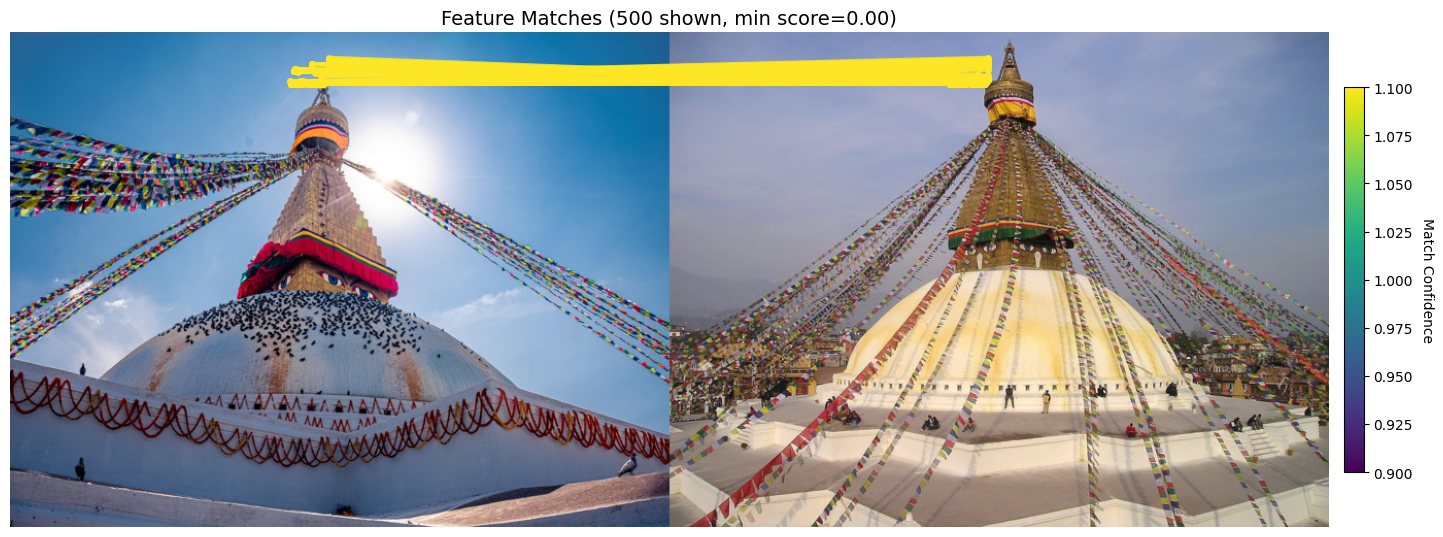

Displaying 500 matches (score ≥ 0.00)
Score range: 1.000 → 1.000
   Refinement complete ✅


In [18]:
img1_url = "https://cdn.pixabay.com/photo/2010/11/29/nepal-403_1280.jpg"
img2_url = "https://cdn.pixabay.com/photo/2020/11/30/06/45/temple-5790023_1280.jpg"

img1 = download_image(img1_url, "img1.jpg")
img2 = download_image(img2_url, "img2.jpg")


run_inference(img2, img1)